# The Nature Conservancy Fisheries Monitoring - Baseline 
<pre>
mode:  baseline
arch:  resnet50
seed:  0
</pre>

In [ ]:
import platform
import random
import torch
import torchvision
import fastai
from fastai.vision.all import *
import albumentations
from albumentations import (
    Compose,GaussianBlur,HorizontalFlip,MedianBlur,MotionBlur,OneOf,
    RandomBrightness,RandomContrast,Resize,ShiftScaleRotate,VerticalFlip
)
import cv2
import sklearn
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

print('python version:       {}'.format(platform.python_version()))
print('torch version:        {}'.format(torch.__version__))
print('torchvision version:  {}'.format(torchvision.__version__))
print('fastai version:       {}'.format(fastai.__version__))
print('albumination version: {}'.format(albumentations.__version__))
print('opencv version:       {}'.format(cv2.__version__))
print('sklearn version:      {}'.format(sklearn.__version__))
print('pandas version:       {}'.format(pd.__version__))
print('numpy version:        {}'.format(np.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:       {}'.format(use_cuda))
print('cuDNN enabled:        {}'.format(torch.backends.cudnn.enabled))
print('num gpus:             {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                  {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:       3.7.10
torch version:        1.7.0
torchvision version:  0.8.1
fastai version:       2.3.0
albumination version: 0.5.2
opencv version:       4.5.1
sklearn version:      0.24.1
pandas version:       1.1.5
numpy version:        1.19.5
CUDA available:       True
cuDNN enabled:        True
num gpus:             1
gpu:                  Tesla P100-PCIE-16GB

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
seed = 0

data_dir = Path('./train')

## Load Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg2.7z
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg2.csv.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg1.csv.zip


In [ ]:
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip .
!unzip train.zip
!rm train/.DS_Store

Archive:  train.zip
   creating: train/
  inflating: train/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/train/
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/ALB/
  inflating: train/ALB/img_00003.jpg  
  inflating: train/ALB/img_00010.jpg  
  inflating: train/ALB/img_00012.jpg  
  inflating: train/ALB/img_00015.jpg  
  inflating: train/ALB/img_00019.jpg  
  inflating: train/ALB/img_00020.jpg  
  inflating: train/ALB/img_00029.jpg  
  inflating: train/ALB/img_00032.jpg  
  inflating: train/ALB/img_00037.jpg  
  inflating: train/ALB/img_00038.jpg  
  inflating: train/ALB/img_00039.jpg  
  inflating: train/ALB/img_00041.jpg  
  inflating: train/ALB/img_00043.jpg  
  inflating: train/ALB/img_00045.jpg  
  inflating: train/ALB/img_00055.jpg  
  inflating: train/ALB/img_00057.jpg  
  inflating: train/ALB/img_00074.jpg  
  inflating: train/ALB/img_00085.jpg  
  inflating: train/ALB/img_00090.jpg  
  inflating: train/ALB/img_00097.jpg  
  inflating: train/ALB/i

In [ ]:
# Create DataFrame from Dataset
df_data = []
labels = []
for c in data_dir.iterdir():
    labels.append(c.name)
    for f in c.iterdir():
        df_entry = [c.name + '/' + f.name, c.name]
        df_data.append(df_entry)
        
train_df = pd.DataFrame(df_data, columns=['image','label'])
print('Labels: {}'.format(labels)); print(); train_df

Labels: ['SHARK', 'ALB', 'NoF', 'DOL', 'LAG', 'YFT', 'OTHER', 'BET']



,image,label
0,SHARK/img_05366.jpg,SHARK
1,SHARK/img_02469.jpg,SHARK
2,SHARK/img_01546.jpg,SHARK
3,SHARK/img_03353.jpg,SHARK
4,SHARK/img_03712.jpg,SHARK
...,...,...
3772,BET/img_06384.jpg,BET
3773,BET/img_02195.jpg,BET
3774,BET/img_03846.jpg,BET
3775,BET/img_05848.jpg,BET


In [ ]:
# Save Data Df
train_df.to_csv('fm_train_df_base_resnet50_s0.csv', index=False)

In [ ]:
# Define Data Augmentation Functions
# similar to: https://isaac-flath.github.io/fastblog/computer%20vision/image%20classification/kaggle/2021/02/15/PlantPathologyKaggle.html
# but without vertical flip (since the image is not from above)

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order = None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']

        return PILImage.create(aug_img)
    
    
def get_train_aug(image_size): 
    return Compose([
        Resize(height=image_size[0], width=image_size[1]),
        OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
    ])


def get_valid_aug(image_size): 
    return  Compose([
        Resize(height=image_size[0], width=image_size[1]),
    ])

In [ ]:
# Load Data into Fastai DataLoader and Add Data Augmentation Functions
set_seed(seed, reproducible=True)

image_size = [224,244]
item_tfms  = [AlbumentationsTransform(get_train_aug(image_size), get_valid_aug(image_size))]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()), 
    getters=[ColReader('image', pref=data_dir), ColReader('label')], 
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = db.dataloaders(source=train_df, bs=25, seed=seed)

print('Classes: {}'.format(dls.vocab)); print()
print('Train Samples: {}'.format(len(dls.train_ds)))
print('Valid Samples: {}'.format(len(dls.valid_ds)))
print('Total Samples: {}'.format(len(dls.train_ds) + len(dls.valid_ds)))

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


Classes: ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

Train Samples: 3022
Valid Samples: 755
Total Samples: 3777


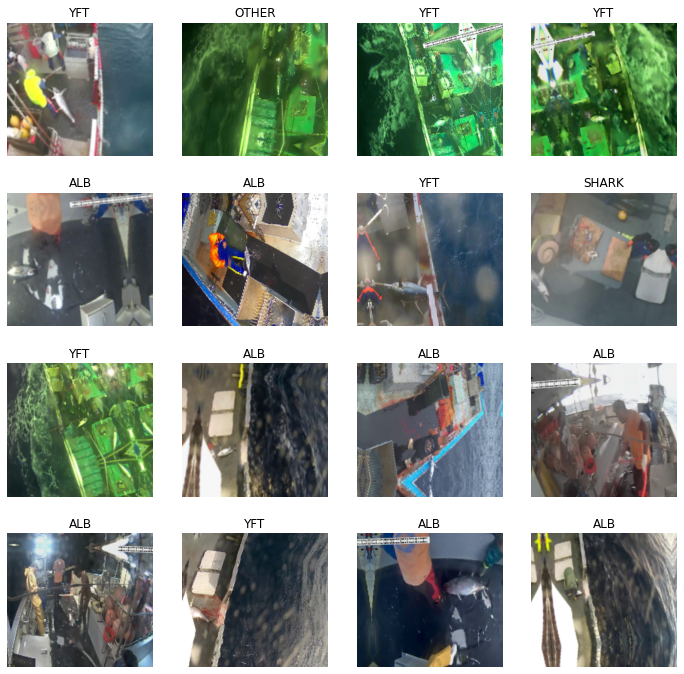

In [ ]:
# Show a few Samples
dls.show_batch(max_n=16)

## Model Training

In [ ]:
# Define Metric
# actual metric is loss, see: https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/overview/evaluation
# but we also use ROC AUC here

def comp_mean_roc_auc(preds, targs, labels=range(len(labels))):
    targs = np.eye(8)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def ALB_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[0])

def BET_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[1])

def DOL_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[2])

def LAG_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[3])

def NoF_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[4])

def OTHER_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[5])

def SHARK_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[6])

def YFT_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[7])

# Add Competition Matric and Some Other Metrics
metrics = [
    AccumMetric(comp_mean_roc_auc, flatten=False),
    AccumMetric(ALB_roc_auc, flatten=False),
    AccumMetric(BET_roc_auc, flatten=False),
    AccumMetric(DOL_roc_auc, flatten=False),
    AccumMetric(LAG_roc_auc, flatten=False),
    AccumMetric(NoF_roc_auc, flatten=False),
    AccumMetric(OTHER_roc_auc, flatten=False),
    AccumMetric(SHARK_roc_auc, flatten=False),
    AccumMetric(YFT_roc_auc, flatten=False),
    accuracy,
]

In [ ]:
# Create Learner
set_seed(seed, reproducible=True)

learn = cnn_learner(
    dls, resnet50, metrics = metrics
).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.04786301031708717)

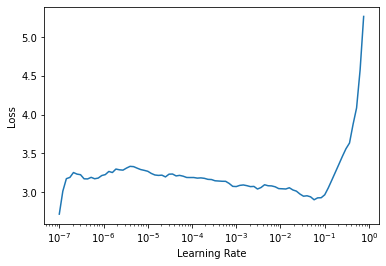

In [ ]:
# Find Learning Rate
set_seed(seed, reproducible=True)

learn.lr_find()

In [ ]:
# Model Training
set_seed(seed, reproducible=True)

learn.fine_tune(8, base_lr=1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,comp_mean_roc_auc,ALB_roc_auc,BET_roc_auc,DOL_roc_auc,LAG_roc_auc,NoF_roc_auc,OTHER_roc_auc,SHARK_roc_auc,YFT_roc_auc,accuracy,time
0,1.819456,1.009032,0.882536,0.835840,0.830745,0.984053,0.786900,0.941457,0.827234,0.958769,0.895292,0.703311,01:07
1,1.378411,0.911046,0.925177,0.839646,0.903627,0.986842,0.995289,0.965674,0.872186,0.922491,0.915664,0.684768,01:07
2,1.173227,0.799252,0.931545,0.845478,0.927336,0.976187,0.998205,0.966500,0.888982,0.982886,0.866785,0.780132,01:07


epoch,train_loss,valid_loss,comp_mean_roc_auc,ALB_roc_auc,BET_roc_auc,DOL_roc_auc,LAG_roc_auc,NoF_roc_auc,OTHER_roc_auc,SHARK_roc_auc,YFT_roc_auc,accuracy,time
0,0.791968,0.626329,0.945749,0.882174,0.881153,0.999785,1.000000,0.969944,0.925301,0.956446,0.951187,0.823841,02:34
1,0.925620,1.011028,0.901294,0.781805,0.913845,0.982766,0.995570,0.966369,0.938546,0.715652,0.915797,0.703311,02:34
2,0.702578,0.479350,0.967039,0.953634,0.913060,0.987021,1.000000,0.973450,0.949434,0.992348,0.967362,0.866225,02:33
3,0.612587,0.514045,0.969001,0.929238,0.966473,0.990704,0.997420,0.974027,0.950083,0.989957,0.954105,0.835762,02:33
4,0.457891,0.577448,0.969945,0.912423,0.976491,0.998999,1.000000,0.989482,0.958466,0.986609,0.937089,0.827815,02:33
5,0.292228,0.249625,0.985388,0.959337,0.989648,0.999857,1.000000,0.982747,0.977988,0.992604,0.980923,0.932450,02:33
6,0.185884,0.201082,0.990348,0.984509,0.996627,1.000000,1.000000,0.984580,0.988007,0.986814,0.982247,0.948344,02:33
7,0.120243,0.190697,0.990651,0.987179,0.997763,1.000000,1.000000,0.983767,0.989244,0.984918,0.982335,0.952318,02:33


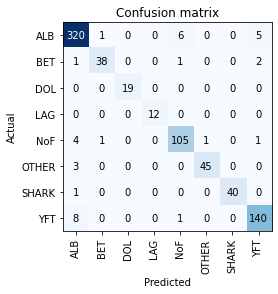

In [ ]:
# Plot Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

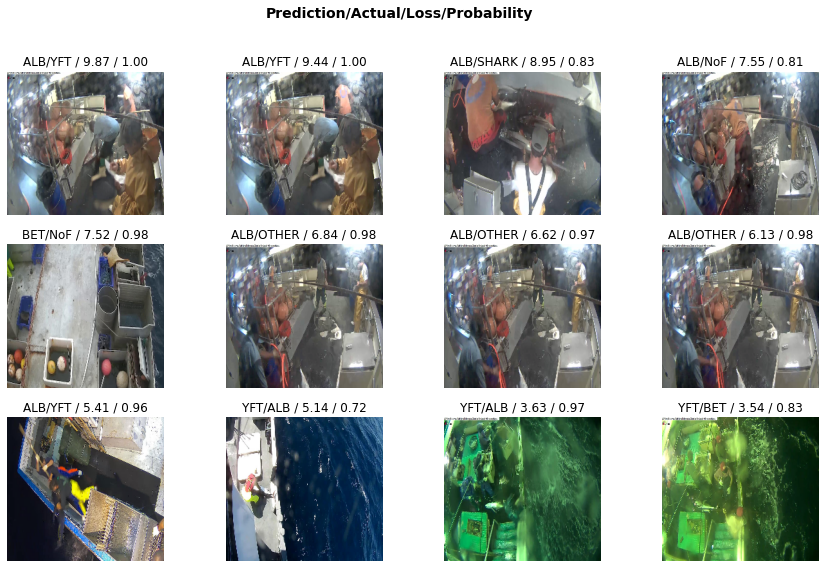

In [ ]:
# Plot Top Losses
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [ ]:
# Print Most Confused Classes
interp.most_confused()

[('YFT', 'ALB', 8),
 ('ALB', 'NoF', 6),
 ('ALB', 'YFT', 5),
 ('NoF', 'ALB', 4),
 ('OTHER', 'ALB', 3),
 ('BET', 'YFT', 2),
 ('ALB', 'BET', 1),
 ('BET', 'ALB', 1),
 ('BET', 'NoF', 1),
 ('NoF', 'BET', 1),
 ('NoF', 'OTHER', 1),
 ('NoF', 'YFT', 1),
 ('SHARK', 'ALB', 1),
 ('YFT', 'NoF', 1)]

In [ ]:
# Save Model
learn.save('fm_base_resnet50_s0_fastai')
torch.save(learn.model, 'fm_base_resnet50_s0.pth')

## Test Set Predictions

In [ ]:
!apt-get install p7zip
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-full
The following NEW packages will be installed:
  p7zip
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 358 kB of archives.
After this operation, 996 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Fetched 358 kB in 0s (2044 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 100757 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Setting up p7zip (16.02+dfsg-6) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip-full
0 upgraded, 1 ne

In [ ]:
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1.zip .
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg2.7z .
!unzip test_stg1.zip
!mv test_stg1/* train
!mkdir train/test_stg2
!7z e test_stg2.7z -otrain/test_stg2
!rm -rf test_stg1

Archive:  test_stg1.zip
   creating: test_stg1/
  inflating: test_stg1/img_00005.jpg  
  inflating: test_stg1/img_00007.jpg  
  inflating: test_stg1/img_00009.jpg  
  inflating: test_stg1/img_00018.jpg  
  inflating: test_stg1/img_00027.jpg  
  inflating: test_stg1/img_00030.jpg  
  inflating: test_stg1/img_00040.jpg  
  inflating: test_stg1/img_00046.jpg  
  inflating: test_stg1/img_00053.jpg  
  inflating: test_stg1/img_00071.jpg  
  inflating: test_stg1/img_00075.jpg  
  inflating: test_stg1/img_00102.jpg  
  inflating: test_stg1/img_00103.jpg  
  inflating: test_stg1/img_00109.jpg  
  inflating: test_stg1/img_00119.jpg  
  inflating: test_stg1/img_00120.jpg  
  inflating: test_stg1/img_00125.jpg  
  inflating: test_stg1/img_00128.jpg  
  inflating: test_stg1/img_00129.jpg  
  inflating: test_stg1/img_00133.jpg  
  inflating: test_stg1/img_00138.jpg  
  inflating: test_stg1/img_00141.jpg  
  inflating: test_stg1/img_00152.jpg  
  inflating: test_stg1/img_00161.jpg  
  inflating: tes

In [ ]:
# Create Predictions of Testset
test_df = pd.read_csv('/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg2.csv.zip')[['image']]
test_dl = dls.test_dl(test_df)

test_preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
# Create Submission DataFrame
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1); sub_df

,image,SHARK,ALB,NoF,DOL,LAG,YFT,OTHER,BET
0,img_00005.jpg,0.000123,5.680065e-08,2.177392e-07,5.262686e-09,0.999876,7.855245e-08,3.589912e-07,7.001304e-07
1,img_00007.jpg,0.863605,4.475709e-03,8.498357e-04,1.870491e-04,0.000405,3.550098e-03,5.931923e-05,1.268680e-01
2,img_00009.jpg,0.982261,1.694780e-03,4.348306e-04,7.322353e-03,0.003711,4.016606e-03,4.878664e-05,5.103581e-04
3,img_00018.jpg,0.981465,3.664583e-03,1.564382e-04,3.377117e-04,0.003124,8.999348e-03,8.243715e-05,2.170134e-03
4,img_00027.jpg,0.738696,3.720549e-03,2.983267e-04,1.200470e-05,0.008651,2.356408e-01,1.182211e-03,1.179937e-02
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_12149.jpg,0.906949,4.163256e-03,1.009349e-03,3.515574e-04,0.065443,3.444726e-03,1.115067e-03,1.752368e-02
13149,test_stg2/image_12150.jpg,0.532932,1.782655e-02,3.053488e-03,1.719299e-04,0.320098,1.063851e-01,9.202743e-05,1.944050e-02
13150,test_stg2/image_12151.jpg,0.012119,2.038667e-03,1.713543e-04,3.853418e-05,0.004344,9.481582e-05,4.392811e-04,9.807540e-01
13151,test_stg2/image_12152.jpg,0.027853,2.252765e-04,4.332551e-06,1.031237e-05,0.934163,8.208145e-04,4.882199e-04,3.643430e-02


In [ ]:
# Save Submission DataFrame 
sub_df.to_csv('sub_fm_base_resnet50_s0.csv', index=False)